In [1]:
version = 'v20250521'

import pandas as pd
from sklearn.model_selection import GroupKFold,cross_val_predict
from skmap.misc import find_files, GoogleSheet, ttprint
import joblib
import numpy as np


## Read in Series ($\beta$) and Pairs ($\delta$)

In [2]:
srs = pd.read_parquet(f'./metric/srs_predicted_{version}.pq')
srs = srs[srs.columns[0:21].tolist()+srs.columns[-24::].tolist()]

srs = srs.rename(columns={'slope_pred':'pred_pnt', 'slope_std':'noise_pnt','pred':'pred_srs','pred_std':'noise_srs'})
srs['signal_pnt'] = srs['pred_pnt'].abs()
srs['signal_srs'] = srs['pred_srs'].abs()
srs['snr_pnt'] = srs['signal_pnt']/srs['noise_pnt']
srs['snr_srs'] = srs['signal_srs']/srs['noise_srs']
srs['error'] = srs['pred_pnt'] - srs['slope_obsv']
srs['rae'] = srs['error'].abs()/srs['slope_obsv'].abs()
srs['abs_error'] = srs['error'].abs()
srs.loc[srs['slope_obsv'].abs()<0.5, 'rae'] =  srs.loc[srs['slope_obsv'].abs()<0.5, 'abs_error']/0.5


srs['time_span'] = srs['time_series'].str[2]-srs['time_series'].str[0]
srs['time_str'] = srs['time_series'].str[0].astype(str) + '-' + srs['time_series'].str[1].astype(str) + '-' + srs['time_series'].str[2].astype(str)

In [3]:
pair = pd.read_parquet(f'./metric/pair_predicted_{version}.pq')
pair = pair.drop(columns=['time_pair_y','lc_survey_pair_x','pred_pair'])
pair = pair.rename(columns={'pred_change_pnt':'pred_pnt','pred':'pred_pair','pred_std':'noise_pair',
                            'time_pair_x':'time_pair','lc_survey_pair_y':'lc_survey_pair'})
pair['signal_pnt'] = pair['pred_pnt'].abs()
pair['signal_pair'] = pair['pred_pair'].abs()
pair['snr_pnt'] = pair['signal_pnt']/pair['noise_pnt']
pair['snr_pair'] = pair['signal_pair']/pair['noise_pair']
pair['lc_str'] = pair['lc_survey_pair'].str[0] + '-' + pair['lc_survey_pair'].str[1]
pair['error'] = pair['pred_pnt'] - pair['soc_change']
pair['abs_error'] = pair['error'].abs()
pair['rae'] = pair['abs_error']/pair['soc_change'].abs()
pair.loc[pair['soc_change'].abs()<1, 'rae'] =  pair.loc[pair['soc_change'].abs()<1, 'abs_error'] # "normalize" rae, with detectability floor == 1


pair['lc_str'] = pair['lc_survey_pair'].str[0] + '-' + pair['lc_survey_pair'].str[1]
pair['time_span'] = pair['time_pair'].str[1] - pair['time_pair'].str[0]

# des_p = pair.groupby('time_span')[['signal','noise_pnt','noise_pair','snr_pnt','snr_pair']].agg(['count','mean', 'median', 'std']).T


## Plot individual time series

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_site_timeseries_and_preds(srs, pair, site_selector, selector_kind='id'):
    """
    Visualizes (A) observed SOC time series, (B) predicted slope (state-first vs change-first),
    and (C) predicted pairwise change per period (state-first vs change-first)
    for a single site.

    Expects srs cols: ['id','lat','lon','time_series','soc_series','pred_pnt','pred_srs', ...]
            pair cols: ['id','lat','lon','time_pair','pred_pnt','pred_pair', ...]
    """
    # ---- select site ----
    if selector_kind == 'id':
        srs_site = srs[srs['id'] == site_selector].copy()
        pair_site = pair[pair['id'] == site_selector].copy()
        site_label = f"id={site_selector}"
    else:
        raise ValueError("selector_kind must be 'id' or 'coords'")

    if srs_site.empty:
        print("No srs record for this site.")
        return
    srs_row = srs_site.iloc[0]

    # ---- extract observed series ----
    # If your SOC series is stored differently, adapt here:
    years = np.array(srs_row['time_series'], dtype=float)
    socs  = np.array(srs_row['soc_series'],  dtype=float)

    # ---- extract slopes (site level) ----
    slope_state  = float(srs_row['pred_pnt'])  # state-first slope (β̂ from state-first)
    slope_change = float(srs_row['pred_srs'])  # change-first slope (β̂ from change-first)

    # ---- prepare pairwise changes ----
    # Build labels like "2009–2015"
    def pair_label(tp):
        return f"{int(tp[0])}–{int(tp[1])}"

    if 'time_pair' in pair_site.columns:
        pair_site = pair_site.copy()
        pair_site['pair_label'] = pair_site['time_pair'].apply(pair_label)
    else:
        raise KeyError("pair['time_pair'] is required to label periods.")

    # sort chronologically
    pair_site = pair_site.copy()
    pair_site['year_start'] = pair_site['time_pair'].apply(lambda x: x[0] if isinstance(x, (list, tuple, np.ndarray)) else x)
    pair_site = pair_site.sort_values(by='year_start')

    labels = list(pair_site['pair_label'])
    change_state  = pair_site['pred_pnt'].astype(float).to_list()   # state-first δ̂ per period
    change_change = pair_site['pred_pair'].astype(float).to_list()  # change-first δ̂ per period

    # ---- plotting ----
    fig = plt.figure(figsize=(11, 12))

    # (A) Observed SOC time series
    ax1 = fig.add_subplot(3,1,1)
    ax1.plot(years, socs, marker='o')
    for x, y in zip(years, socs):
        ax1.annotate(f"{y:.1f}", (x, y), textcoords="offset points", xytext=(0,6), ha='center', fontsize=10)
    ax1.set_title(f"(A) Observed SOC time series — {site_label}", fontsize=16)
    ax1.set_xlabel("Year", fontsize=16)
    ax1.set_ylim([min(socs)-1, max(socs)+1])
    ax1.set_ylabel("SOC (g/kg)", fontsize=16)

    # (B) Predicted slope (site)
    ax2 = fig.add_subplot(3,1,2)
    bars = ax2.bar(['State-first', 'Change-first'],
                   [slope_state,        slope_change], alpha=0.6)
    ax2.axhline(0, linestyle='--', linewidth=1)
    for rect, val in zip(bars, [slope_state, slope_change]):
        ax2.text(rect.get_x() + rect.get_width()/2, 
                 rect.get_height()-0.005 if rect.get_height()>0 else rect.get_height()+0.005,
                 f"{val:.2f}", ha='center', va='bottom', fontsize=10)
    ax2.set_title("(B) Predicted slope at site", fontsize=16)
    ax2.set_ylabel(r"$\hat\beta$ (g/kg/year)", fontsize=16)

    # (C) Predicted pairwise changes per period
    ax3 = fig.add_subplot(3,1,3)
    x = np.arange(len(labels))
    width = 0.42
    b1 = ax3.bar(x - width/2, change_state,  width=width, alpha=0.6, label='State-first')
    b2 = ax3.bar(x + width/2, change_change, width=width, alpha=0.6, label='Change-first')
    ax3.axhline(0, linestyle='--', linewidth=1)
    ax3.set_xticks(x, labels, rotation=0)
    ax3.set_title("(C) Predicted pairwise changes", fontsize=16)
    ax3.set_xlabel("Period", fontsize=16)
    ax3.set_ylabel("$\hat\delta$ (g/kg)", fontsize=16)
    ax3.legend()

    # annotate bars
    for rects in (b1, b2):
        for rect in rects:
            val = rect.get_height()
            ax3.text(rect.get_x() + rect.get_width()/2,
                     rect.get_height()-0.2 if rect.get_height()>0 else rect.get_height()+0.2,
                     f"{val:.2f}",
                     ha='center', va='bottom', fontsize=10)

    fig.tight_layout()
    plt.show()

# plot_site_timeseries_and_preds(srs, pair, site_selector=12345, selector_kind='id')


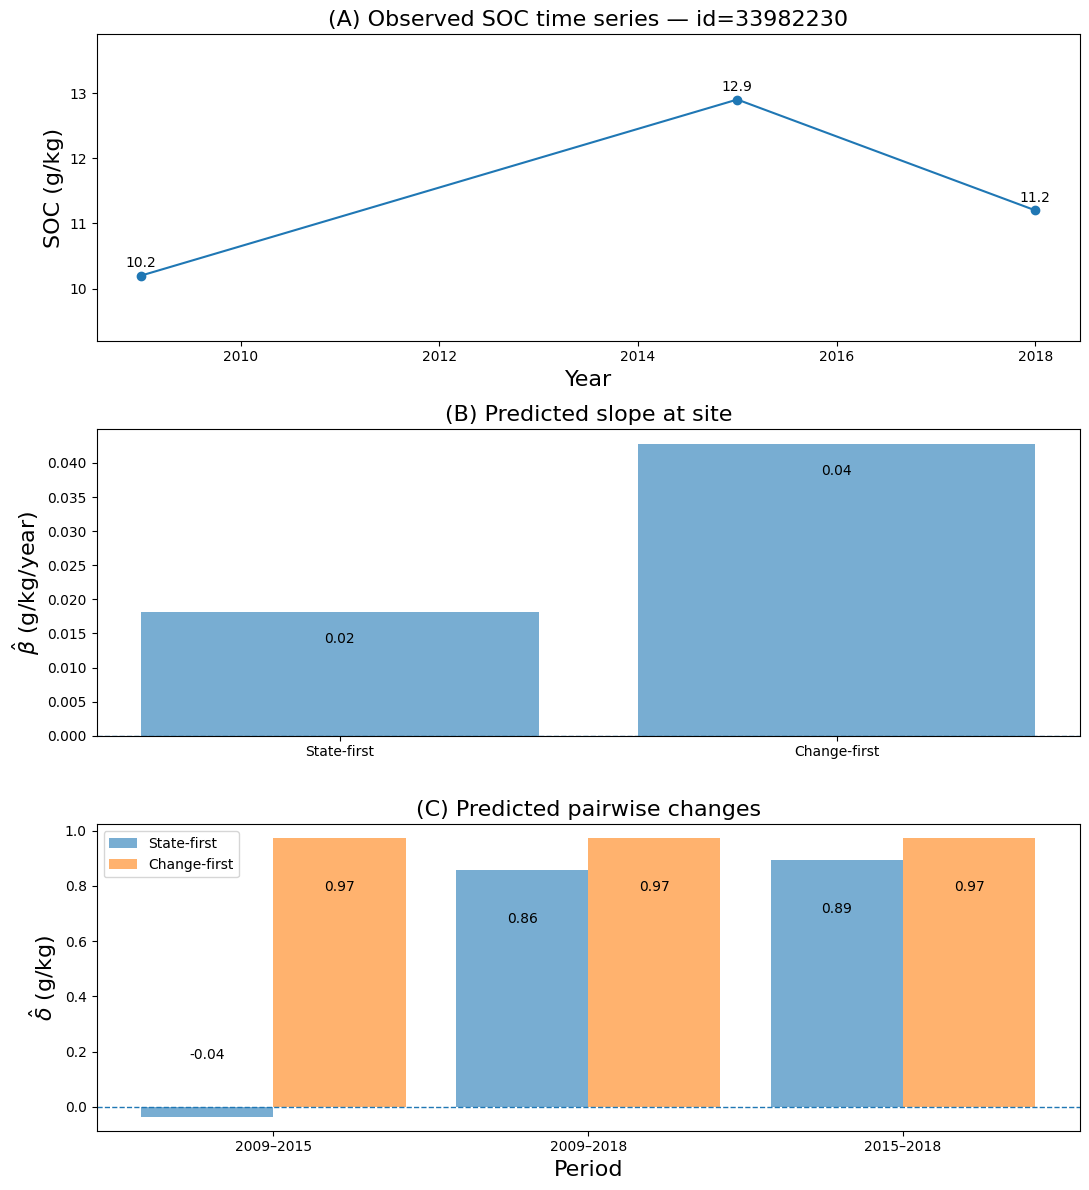

-------------------------------------------------


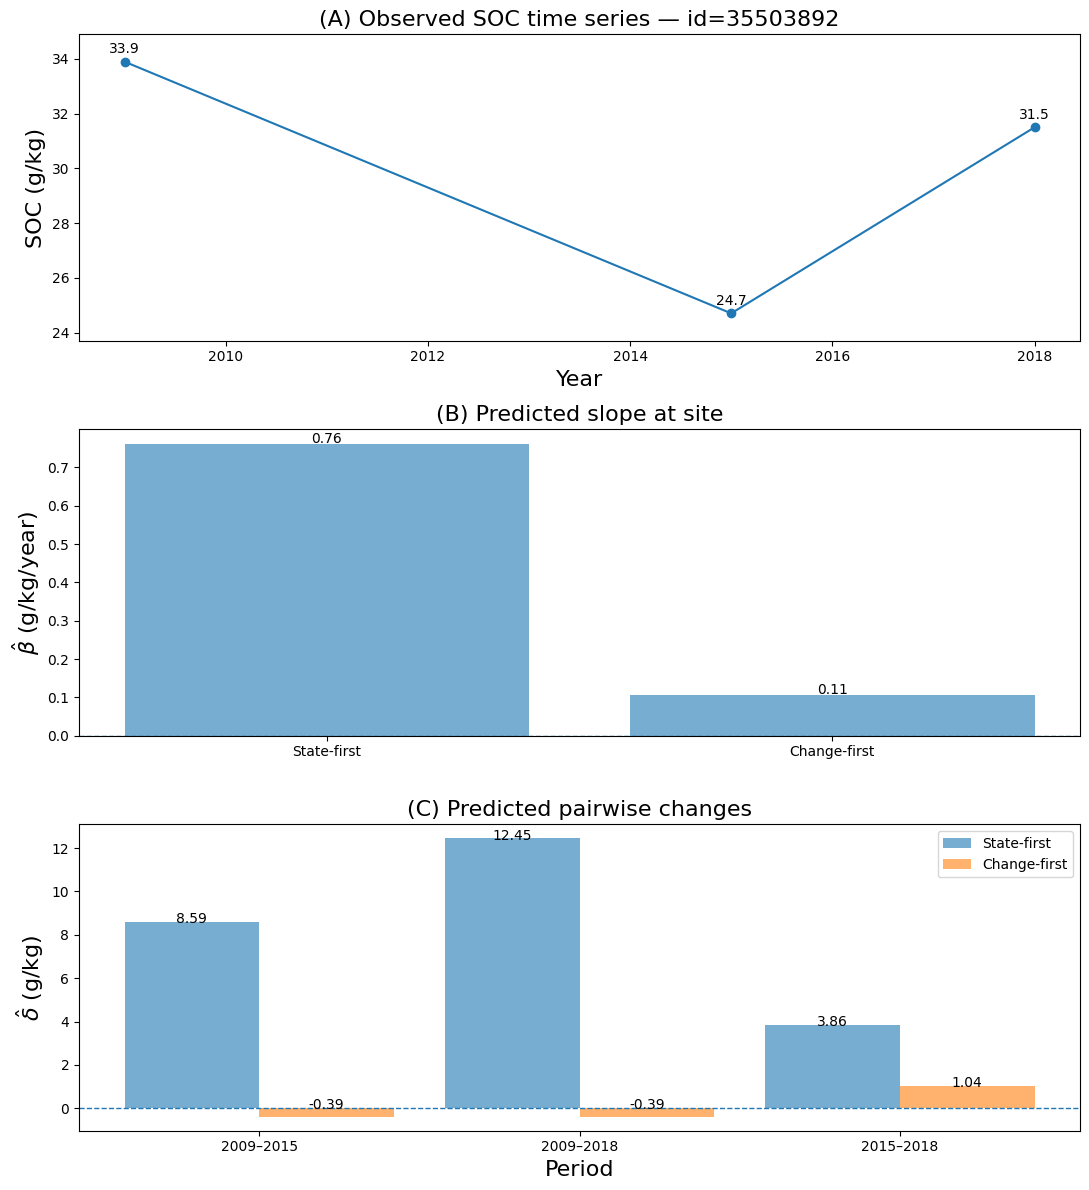

-------------------------------------------------


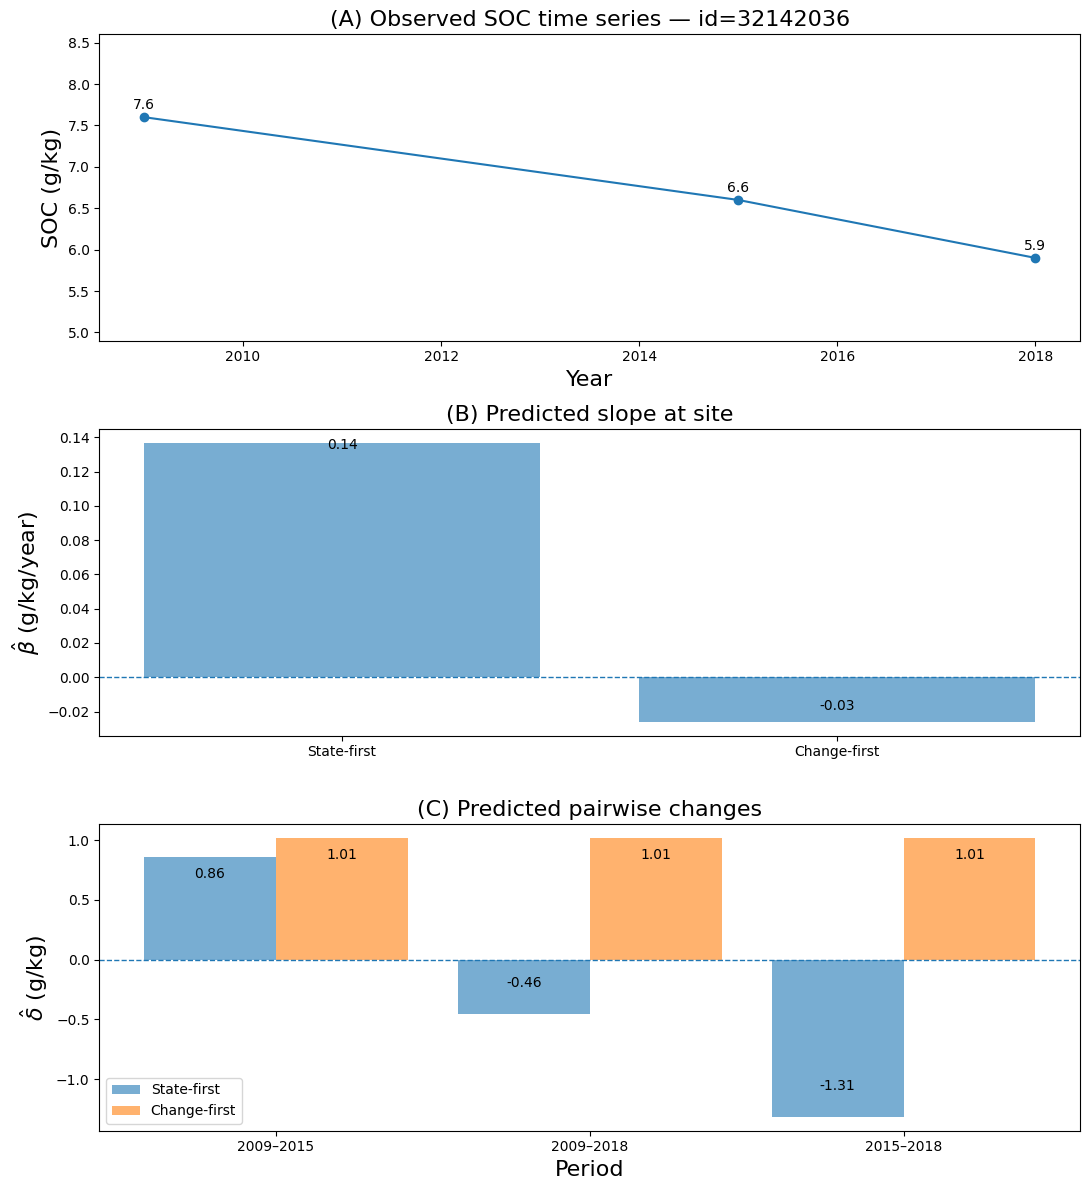

-------------------------------------------------


In [70]:
for iss in srs.sample(3)['id'].values.tolist():
    plot_site_timeseries_and_preds(srs, pair, site_selector=iss, selector_kind='id')
    print('-------------------------------------------------')


Across the examined time series, we observed systematic but modest differences between the state-first and change-first approaches. 

For $\hat\beta$, the change-first approach generally produced smaller magnitudes. This likely reflects the smoothing effect of trend fitting across multiple time points, where short-term fluctuations between consecutive observations are averaged out. In contrast, the state-first approach models SOC states independently at each time step; as a result, local fluctuations in predicted SOC values are retained, often leading to larger apparent slope magnitudes.

For $\hat\delta$, predictions from the state-first approach tended to show greater variability than those from the change-first approach. This can be attributed to the difference in modeling targets: while the state-first models operate on absolute SOC levels, the change-first models directly predict SOC differences, which are typically small in magnitude and less variable. 

These patterns, however, should be interpreted with caution, as high model noise and limited predictive accuracy restrict meaningful inference about underlying drivers. Moreover, with only three temporal observations, trend fitting itself is inherently uncertain and primarily illustrative rather than diagnostic.